#**Final Report**





La industria aérea es altamente competitiva, donde la experiencia del cliente juega un rol central en la retención y fidelización. United Airlines enfrenta importantes desafíos para destacar frente a sus competidores, especialmente en áreas relacionadas con la percepción de valor y satisfacción general. Este análisis tiene como objetivo identificar segmentos de clientes, detectar factores críticos que impactan la experiencia y desarrollar estrategias basadas en datos para mejorar la posición competitiva de United.

Para lograrlo, se utilizó un enfoque combinado de:

1. Análisis de sentimientos basado en reseñas y analisis de topicos

2. Segmentación de clientes mediante clustering.

3. Creación de un modelo predictivo para determinar los factores que afectan la recomendación del servicio.

Este trabajo no solo proporciona una visión detallada de las fortalezas y debilidades de United, sino que también establece una hoja de ruta para mejorar su desempeño y percepción entre los clientes.


## Carga y Preprocesamiento de Datos

In [ ]:
import pandas as pd
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Instalar nltk
!pip install --quiet nltk

# Importar y descargar recursos necesarios
import nltk
nltk.download('vader_lexicon')  # Para análisis de sentimientos
nltk.download('punkt')          # Para tokenización
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.nn.functional import softmax
from tqdm import tqdm


# Cargar el modelo BERT especializado para análisis de sentimientos
from transformers import AutoTokenizer, AutoModelForSequenceClassification

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data_clustering = pd.read_csv('/content/balanced_airline_reviews.csv')
data_clustering.shape

(17150, 34)

# Segmentación de Clientes: Identificación de clusters y sus características.

## Modelo Seleccionado: K-Means

Este modelo es ideal para segmentar clientes en grupos homogéneos basándose en patrones de comportamiento. La reducción de dimensionalidad con PCA facilita la visualización y mejora el rendimiento del clustering en datos de alta dimensionalidad.

- Objetivo: Identificar grupos de clientes con necesidades y comportamientos similares.

- Variables: Tipo de viajero, clase, duración del vuelo, satisfacción general, etc.

Estas variables capturan los aspectos esenciales de la experiencia del cliente, asegurando que los clsuters reflejen patrones reales en los datos.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

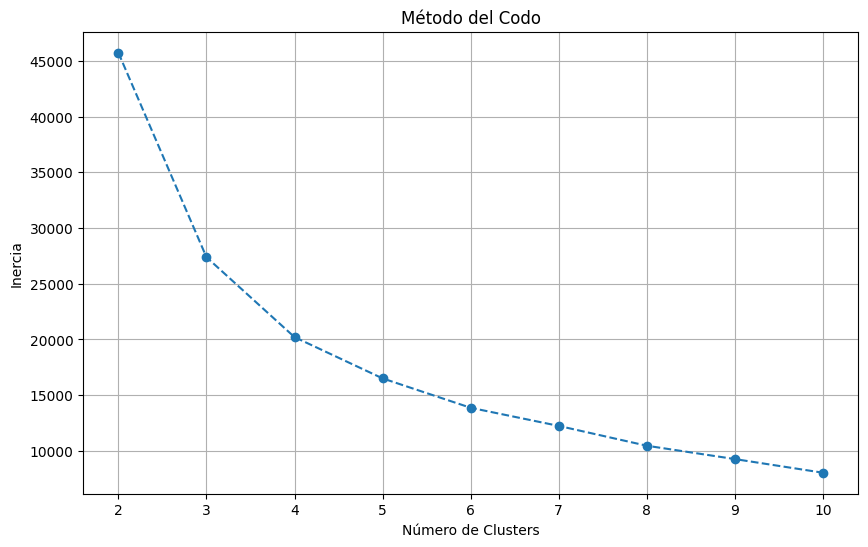

 
Silhouette Scores: {2: 0.6046339286360902, 3: 0.6141793299017735, 4: 0.5833567211678151, 5: 0.5054379744629547, 6: 0.42403835075975804, 7: 0.4075425272541744, 8: 0.4238454506666178, 9: 0.3985377015053134, 10: 0.3967223165848645}
Número óptimo de clusters según Silhouette Score: 3
Mejor Silhouette Score: 0.6142


In [ ]:
# Selección de columnas relevantes para clustering
selected_columns = [
    'overall', 'review_dayofweek', 'review_month', 'review_year',
    'traveller_type', 'cabin', 'seat_comfort', 'cabin_service', 'airline',
    'food_bev', 'ground_service', 'value_for_money', 'route_distance', 'route_time_minutes', "recommended"
]
data_clustering = data_clustering[selected_columns]

# Separar columnas numéricas y categóricas
num_features = ['overall', 'review_dayofweek', 'review_month', 'review_year',
                'seat_comfort', 'cabin_service', 'food_bev', 'ground_service',
                'value_for_money', 'route_distance', 'route_time_minutes', "recommended"]
cat_features = ['traveller_type', 'cabin', 'airline']

# Crear transformadores para numéricas y categóricas
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop='first', sparse_output=False)  # Cambiado a sparse_output

# Preprocesamiento combinado
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

# Reducir dimensionalidad con PCA
pca = PCA(n_components=2, random_state=42)

# Listas para almacenar resultados
inertia = []
silhouette_scores = {}

# Probar con diferentes números de clusters
for n_clusters in range(2, 11):  # Probar entre 2 y 10 clusters
    pipeline_pca = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('pca', pca),
        ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))
    ])
    pipeline_pca.fit(data_clustering)
    clusters = pipeline_pca.predict(data_clustering)

    # Calcular la inercia del modelo KMeans
    inertia.append(pipeline_pca.named_steps['kmeans'].inertia_)

    # Calcular el Silhouette Score
    X_pca = pipeline_pca.named_steps['pca'].transform(
        pipeline_pca.named_steps['preprocessor'].transform(data_clustering)
    )
    silhouette_avg = silhouette_score(X_pca, clusters)
    silhouette_scores[n_clusters] = silhouette_avg

# Identificar el número óptimo de clusters
optimal_clusters = max(silhouette_scores, key=silhouette_scores.get)
optimal_score = silhouette_scores[optimal_clusters]

# Graficar el método del codo
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid()
plt.show()

# Resultados
print(" ")
print("Silhouette Scores:", silhouette_scores)
print("Número óptimo de clusters según Silhouette Score:", optimal_clusters)
print("Mejor Silhouette Score:", optimal_score.round(4))

## Informacion del modelo

#### Entrenamiento y ajuste del modelo

- Determinación del número óptimo de clústeres mediante el método del codo y Silhouette Score.

- PCA para reducir dimensionalidad antes del clustering.

#### Métricas de Evaluación

- Silhouette Score: Evaluación de la cohesión interna y separación entre clústeres.

- Inercia: Mide la compacidad de los clústeres.
- De forma visual: Metodo del codo


#### Interpretación de los Resultados

El análisis de clustering realizado utilizando **K-Means** y evaluado con el **Silhouette Score** arroja los siguientes resultados clave:

##### **1. Número Óptimo de Clústeres**
- **Número Óptimo de Clústeres:** 3.
- **Mejor Silhouette Score:** 0.6152.

El **Silhouette Score** mide la cohesión interna de los clústeres (qué tan similares son los datos dentro de un clúster) y la separación entre clústeres (qué tan distintos son entre sí). Un puntaje más cercano a 1 indica clústeres bien definidos.

En este caso:
- Con 3 clústeres se obtiene el mejor Silhouette Score, lo que sugiere que esta configuración segmenta los datos de manera efectiva, balanceando cohesión interna y separación intergrupal.
- Aunque otros números de clústeres (como 2 o 4) también presentan puntajes razonables, no superan el resultado obtenido con 3 clústeres.

##### **2. Análisis de Silhouette Score por Configuración**
- **2 Clústeres:** Aunque muestra una cohesión aceptable (0.6046), puede ser demasiado general para capturar la diversidad del dataset.
- **3 Clústeres:** Proporciona la mejor relación cohesión-separación, lo que lo hace ideal para identificar segmentos significativos.
- **Más de 3 Clústeres (4 a 10):** A medida que aumenta el número de clústeres, el Silhouette Score disminuye progresivamente, indicando que los grupos se vuelven menos definidos y potencialmente redundantes.

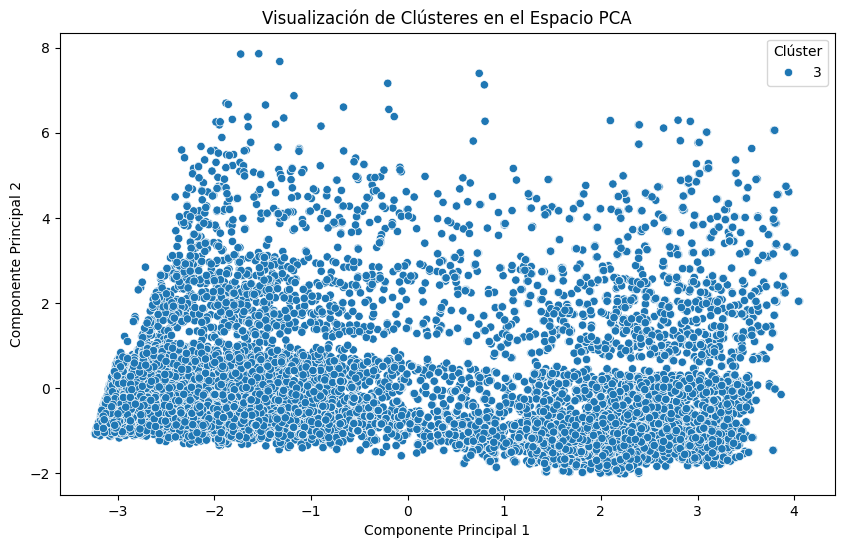

In [ ]:
pca_result = pipeline_pca.named_steps['pca'].transform(
    pipeline_pca.named_steps['preprocessor'].transform(data_clustering)
)

df_pca = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
df_pca['Cluster_KMeans'] = optimal_clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='Cluster_KMeans',
    palette='tab10',
    data=df_pca
)
plt.title('Visualización de Clústeres en el Espacio PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Clúster')
plt.show()

Al graficar los datos, no se distinguen claramente los tres clusters. Por este motivo, se optará por utilizar un gráfico en 3D.

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Reducimos PCA a 3 componentes para graficar en 3D
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(
    preprocessor.fit_transform(data_clustering)
)

# Asignar clusters con el número óptimo encontrado
kmeans_3d = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters_3d = kmeans_3d.fit_predict(X_pca_3d)

# Convertir a DataFrame para plotear
df_3d = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_3d['Cluster'] = clusters_3d

# Crear el gráfico 3D interactivo
fig = px.scatter_3d(
    df_3d, x='PC1', y='PC2', z='PC3',
    color='Cluster', title='Clusters en 3D (PCA)',
    labels={'Cluster': 'Cluster'},
    opacity=0.7
)


fig.show()

Se puede observar que los clusters están claramente diferenciados, lo que sugiere que el modelo de clustering ha logrado segmentar de manera efectiva los datos. La separación entre los grupos, especialmente en la proyección de la tercera componente principal (PC3), indica que las características seleccionadas para el clustering capturan bien las variaciones entre los datos, permitiendo una distinción clara de las agrupaciones.

Se crea un pipeline con el número óptimo de clusters, se entrena el modelo y se asignan las etiquetas de cluster al DataFrame para su análisis posterior.

In [ ]:
# Crear pipeline con el número óptimo de clusters
pipeline_optimal = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('kmeans', KMeans(n_clusters=optimal_clusters, random_state=42))])

# Entrenar con el número óptimo de clusters
pipeline_optimal.fit(data_clustering)
clusters_optimal = pipeline_optimal.predict(data_clustering)

# Asignar los clusters al DataFrame
data_clustering['Cluster'] = clusters_optimal

Se calcula el tamaño de cada cluster para analizar su distribución y se generan los promedios de variables clave por cluster, lo que permite identificar las características principales de cada grupo.

In [ ]:
# Tamaño de cada cluster
cluster_sizes = data_clustering['Cluster'].value_counts()
print("Tamaño de los clusters:\n", cluster_sizes)

Tamaño de los clusters:
 Cluster
0    8210
1    6846
2    2094
Name: count, dtype: int64


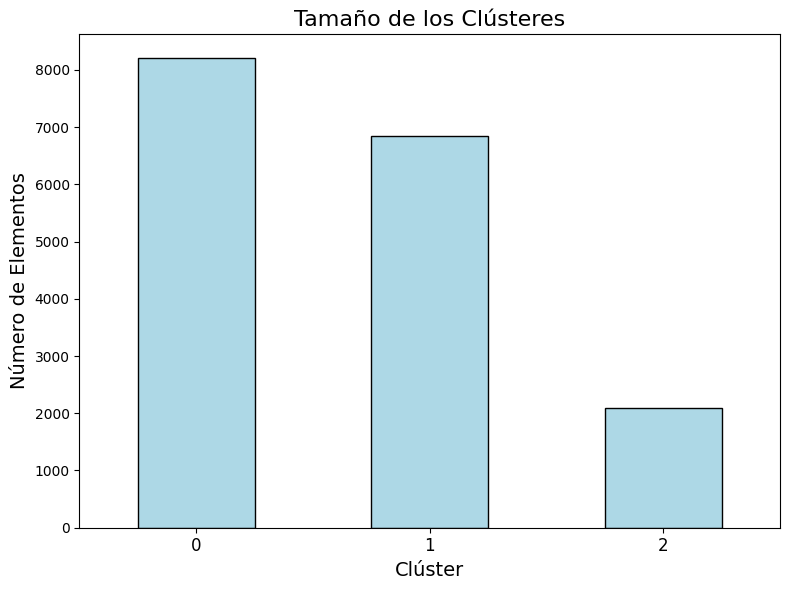

In [ ]:
# Obtener el tamaño de cada clúster
cluster_sizes = data_clustering['Cluster'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
cluster_sizes.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Tamaño de los Clústeres', fontsize=16)
plt.xlabel('Clúster', fontsize=14)
plt.ylabel('Número de Elementos', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

El cluster 0 es el más grande, seguido del cluster 1, mientras que el cluster 2 es significativamente más pequeño. Esto sugiere que el cluster 2 podría representar un grupo más específico o con características menos comunes, mientras que los otros dos agrupan a la mayoría de los datos.

In [ ]:
# Promedios por cluster
summary = data_clustering.groupby('Cluster')[
    ['overall', 'seat_comfort', 'cabin_service', 'food_bev',
     'ground_service', 'value_for_money',  'route_time_minutes']
].mean().round(3)
print("\nPromedios por cluster:\n")

summary


Promedios por cluster:



,overall,seat_comfort,cabin_service,food_bev,ground_service,value_for_money,route_time_minutes
Cluster,,,,,,,
0,1.568,1.633,1.560,1.020,1.354,1.336,177.303
1,8.696,3.994,4.441,3.104,3.762,4.498,162.875
2,6.877,3.566,3.652,3.334,3.283,3.722,697.798


In [ ]:
print("\nPromedios por cluster:\n")
summary[["cabin_service", "ground_service","value_for_money", "route_time_minutes"]]


Promedios por cluster:



,cabin_service,ground_service,value_for_money,route_time_minutes
Cluster,,,,
0,1.560,1.354,1.336,177.303
1,4.441,3.762,4.498,162.875
2,3.652,3.283,3.722,697.798


1. **Cluster 0**:  
   - Este grupo tiene las calificaciones más bajas en todo, parecen ser los más descontentos. Es probable que sean pasajeros que tuvieron experiencias malas o bastante flojas.  
   - Los vuelos son más cortos (177 minutos), lo que podría indicar que se trata de tramos más rápidos o nacionales donde el servicio no fue bien valorado.

2. **Cluster 1**:  
   - Acá están los pasajeros más contentos, con las mejores calificaciones en todas las categorías. Les gustó todo: el asiento, el servicio de cabina y hasta sintieron que valió la pena el precio.  
   - Curiosamente, sus vuelos son un poco más cortos (162 minutos), tal vez nacionales o de buena calidad.

3. **Cluster 2**:  
   - Este grupo está en el medio, ni tan contentos ni tan quejosos. Pero algo que destaca es que tienen vuelos mucho más largos (698 minutos). Todo apunta a que son pasajeros de tramos internacionales que tuvieron una experiencia promedio.

**Resumen**
Los clusters marcan bien la diferencia entre vuelos cortos y largos, y sobre todo entre los que la pasan mal y los que la pasan bien. Podría ser útil enfocarse en mejorar los vuelos cortos (Cluster 0) y asegurarse de cuidar a los de vuelos largos (Cluster 2).

<ipython-input-14-b9c411ed0859>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




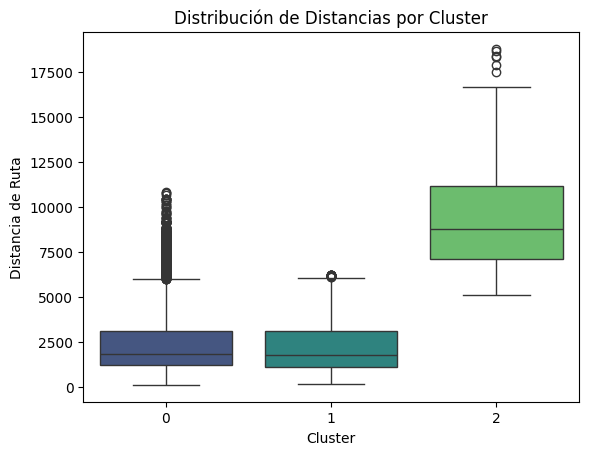

In [ ]:
# Distribución de distancias por cluster
sns.boxplot(data=data_clustering, x='Cluster', y='route_distance', palette='viridis')
plt.title('Distribución de Distancias por Cluster')
plt.ylabel('Distancia de Ruta')
plt.xlabel('Cluster')
plt.show()

Este gráfico muestra cómo se distribuyen las distancias de ruta en cada cluster:

1. **Cluster 0**:
   - La mayoría de los vuelos tienen distancias cortas, con una mediana por debajo de los 2,500 km.
   - Se observan varios valores atípicos con distancias mayores, lo que sugiere que este grupo incluye vuelos cortos y algunos medianos excepcionales.

2. **Cluster 1**:
   - Similar al Cluster 0, aunque con menos valores atípicos y una distribución más concentrada, indicando vuelos cortos y medianos más consistentes.

3. **Cluster 2**:
   - Representa claramente vuelos largos, con distancias significativamente mayores (mediana por encima de 7,500 km) y varios valores extremos que alcanzan hasta 17,500 km.



El Cluster 2 está fuertemente asociado a vuelos de larga distancia, mientras que los Clusters 0 y 1 están relacionados con vuelos cortos o medianos, aunque el Cluster 0 muestra mayor variabilidad. Esto podría indicar diferencias en las características y necesidades de los pasajeros de estos grupos.

**Frecuencia de categorías por cluster**

In [ ]:
category_summary = data_clustering.groupby('Cluster')[['traveller_type', 'cabin']].value_counts()
print("Frecuencia de categorías por cluster:\n", category_summary)

Frecuencia de categorías por cluster:
 Cluster  traveller_type  cabin          
0        Solo Leisure    Economy Class      2873
         Couple Leisure  Economy Class      1761
         Family Leisure  Economy Class      1752
         Business        Economy Class      1118
         Solo Leisure    First Class          81
         Business        First Class          80
         Couple Leisure  Premium Economy      75
         Solo Leisure    Premium Economy      70
         Business        Premium Economy      69
         Couple Leisure  First Class          68
         Business        Business Class       67
         Solo Leisure    Business Class       60
         Family Leisure  Premium Economy      46
                         First Class          40
         Couple Leisure  Business Class       29
         Family Leisure  Business Class       21
1        Solo Leisure    Economy Class      2725
         Family Leisure  Economy Class      1267
         Couple Leisure  Economy Class

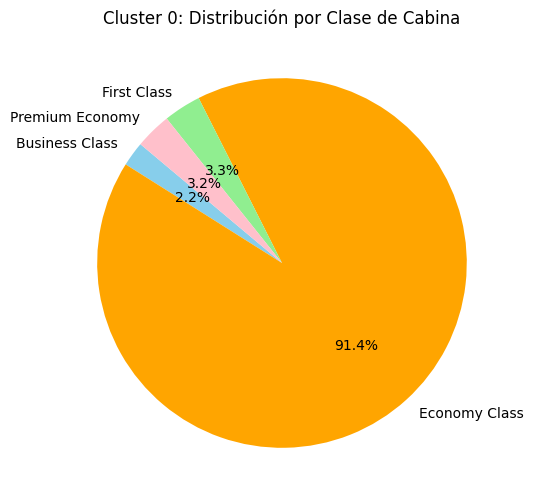

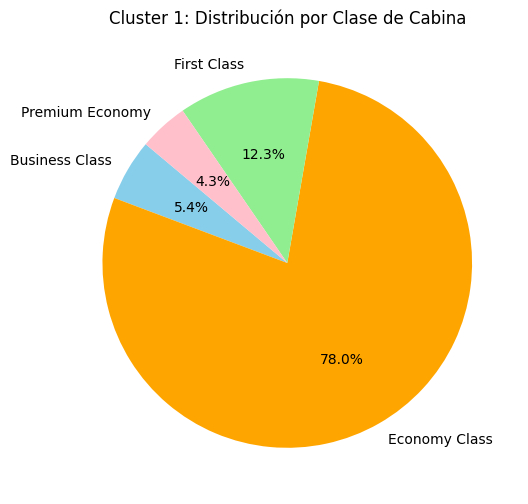

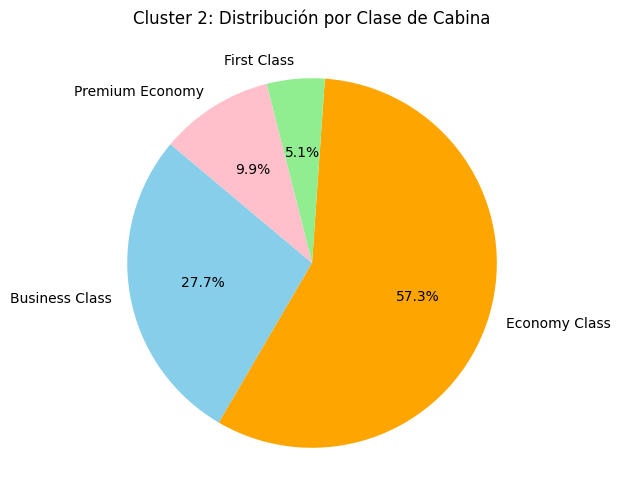

In [ ]:
df_counts = data_clustering.groupby(['Cluster', 'cabin']).size().reset_index(name='count')

clusters = df_counts['Cluster'].unique()

for cluster in clusters:
    subset = df_counts[df_counts['Cluster'] == cluster]

    plt.figure(figsize=(6, 6))
    plt.pie(
        subset['count'],
        labels=subset['cabin'],
        autopct='%1.1f%%',
        startangle=140,
        colors=['skyblue', 'orange', 'lightgreen',"pink" ]
    )
    plt.title(f'Cluster {cluster}: Distribución por Clase de Cabina')
    plt.show()

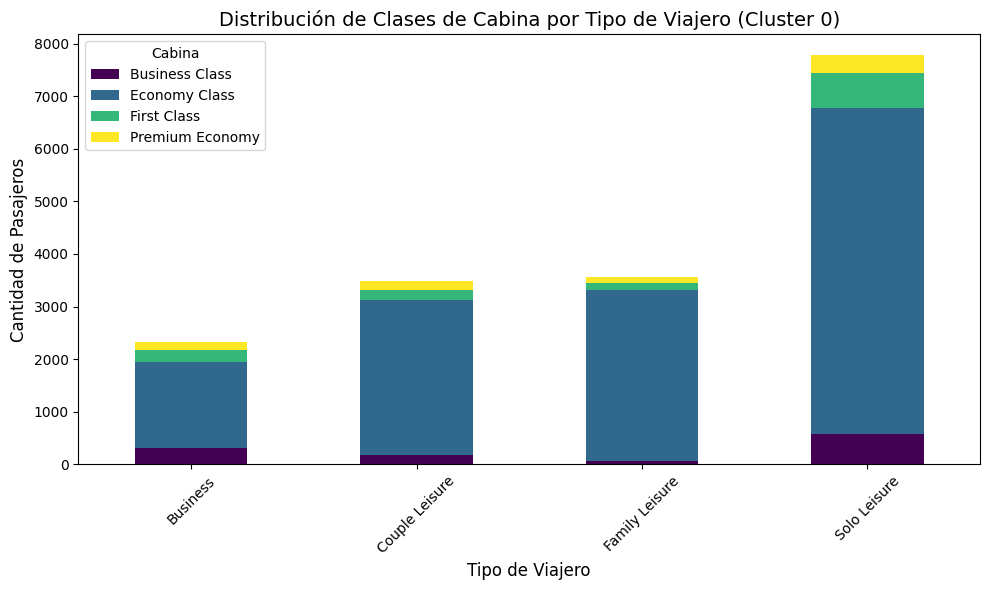

In [ ]:
pivot = df_cluster_0.groupby(['traveller_type', 'cabin']).size().unstack(fill_value=0)

# Crear gráfico de barras apiladas
pivot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

# Configurar etiquetas y título
plt.title('Distribución de Clases de Cabina por Tipo de Viajero (Cluster 0)', fontsize=14)
plt.xlabel('Tipo de Viajero', fontsize=12)
plt.ylabel('Cantidad de Pasajeros', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Cabina', fontsize=10)

plt.tight_layout()
plt.show()

## Clusters Identificados y Acciones Estratégicas

### Cluster 0: Vuelos cortos y mayoritariamente de ocio
Este cluster está compuesto principalmente por pasajeros de ocio (Solo Leisure, Couple Leisure y Family Leisure) que viajan en Economy Class, siendo Solo Leisure en Economy Class el grupo más grande con 2873 casos. La presencia de clases premium es mínima, lo que refuerza la idea de que este grupo está asociado a vuelos cortos y económicos. Sin embargo, es el grupo con las calificaciones más bajas, lo que indica experiencias negativas y una baja percepción de valor.

Acciones Estratégicas:
- Mejorar el servicio básico: Invertir en comodidad de los asientos, puntualidad, y evaluar opciones de snacks y bebidas, incluso en vuelos cortos.

- Beneficios adicionales: Introducir, por ejemplo opciones de embarque prioritario y mejoras en el manejo de equipaje.

---

### Cluster 1: Diversidad y mayor presencia de clases premium
Este cluster combina pasajeros de ocio y negocios, con una representación significativa en First Class y Business Class, aunque Solo Leisure en Economy Class sigue siendo el grupo predominante con 2725 casos. Este grupo tiene las mejores calificaciones y representa un balance entre comodidad y costo, siendo clave para asegurar su fidelización.

Acciones Estratégicas:
- Fidelización: Ofrecer upgrades ocasionales o beneficios como acceso a lounges.
- Mantener la calidad del servicio: Asegurar el confort en vuelos de corta y media distancia, especialmente en clases premium.
- Promociones personalizadas: Diseñar ofertas para viajes grupales o familiares con descuentos y beneficios.

---

### Cluster 2: Premium y vuelos largos
En este cluster se destacan pasajeros en Business Class y Premium Economy, siendo más frecuentes en vuelos largos. Aunque los viajeros de ocio en Economy Class siguen liderando en número, este grupo tiene una mayor inclinación hacia clases superiores. Representa a clientes que valoran comodidad y exclusividad en su experiencia de viaje.

Acciones Estratégicas:
- Personalización del servicio: Mejorar las opciones de comidas y bebidas en clases premium y ofrecer kits de confort para vuelos largos
- Fortalecer la experiencia: Recolectar reseñas positivas y ofrecer beneficios simbólicos a clientes recurrentes en vuelos internacionales.

---

Cluster 0 representa una gran oportunidad para retener clientes con mejoras en el servicio básico y una comunicación efectiva. Cluster 1 está compuesto por clientes satisfechos que pueden ser fidelizados mediante programas de recompensas e incentivos. Cluster 2 agrupa a los viajeros más exigentes, quienes demandan un servicio exclusivo y una experiencia premium de alta calidad.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identificar columnas categóricas y numéricas
categorical_cols = data_clustering.select_dtypes(include=['object']).columns
numerical_cols = data_clustering.select_dtypes(include=['float64', 'int64']).columns.drop('recommended')

# Crear transformadores para preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

# Preparar X e y
X = data_clustering.drop(columns=['recommended'])
y = data_clustering['recommended']

# Crear un pipeline con preprocesamiento y modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

# Entrenar el modelo
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['overall', 'review_dayofweek', 'review_month', 'review_year',
       'seat_comfort', 'cabin_service', 'food_bev', 'ground_service',
       'value_for_money', 'route_distance', 'route_time_minutes'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['traveller_type', 'cabin', 'airline'], dtype='object'))])),
                ('model', RandomForestClassifier(random_state=42))])

Importancia de Características (Transformadas):


,Feature,Importance
0,overall,0.307446
8,value_for_money,0.250296
4,seat_comfort,0.120871
5,cabin_service,0.105543
7,ground_service,0.087660
6,food_bev,0.039393
3,review_year,0.016373
10,route_time_minutes,0.016328
9,route_distance,0.016216
2,review_month,0.009091


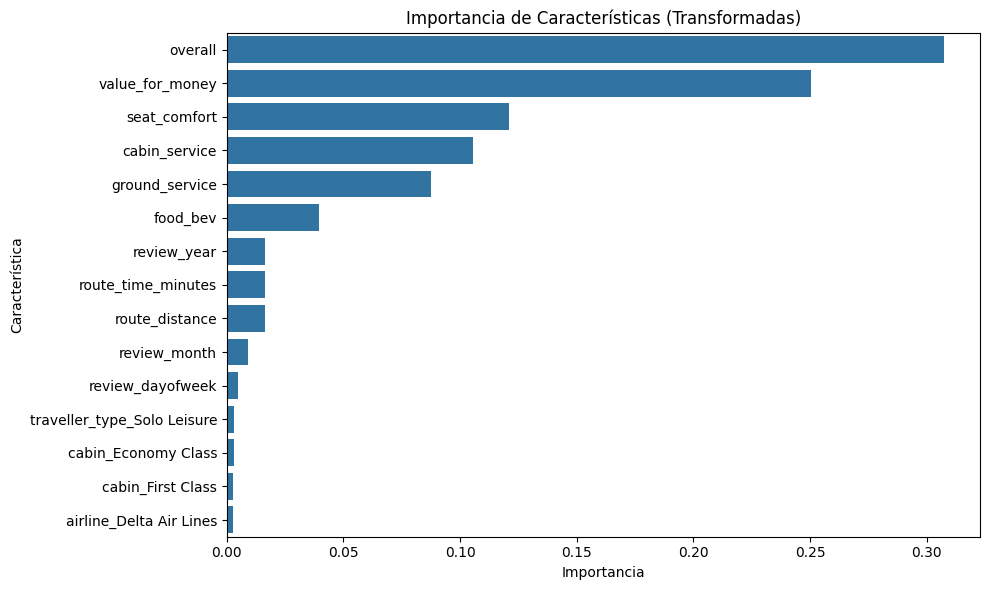

In [ ]:
# Extraer el modelo RandomForest entrenado
rf_model = pipeline.named_steps['model']

# Obtener importancia de características transformadas
feature_importances = rf_model.feature_importances_

# Obtener nombres de las características transformadas
cat_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols.tolist() + cat_feature_names.tolist()

# Crear un DataFrame con las importancias
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Mostrar las importancias
print("Importancia de Características (Transformadas):")
display(importance_df)

# Visualizar las importancias globales
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))  # Mostrar las 15 más importantes
plt.title('Importancia de Características (Transformadas)')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

### Insights de la Importancia de las Características:

1. **Factores más influyentes**:
   - La variable **`overall`** (calificación general) es, por lejos, la característica más importante, representando más del 30% de la importancia total. Esto indica que la percepción global del servicio es clave para predecir si un cliente recomendará el vuelo.
   - **`value_for_money`** (relación calidad-precio) es el segundo factor más importante (25%), lo que sugiere que los pasajeros valoran especialmente la percepción de que el servicio justifique el costo.
   - **`seat_comfort`** (comodidad del asiento) y **`cabin_service`** (servicio en cabina) también son altamente relevantes, destacando que la experiencia a bordo tiene un impacto significativo en la satisfacción del cliente.

2. **Factores secundarios**:
   - **`ground_service`** (servicio en tierra) y **`food_bev`** (comida y bebidas) tienen menor peso, pero siguen siendo relevantes, indicando que los servicios adicionales afectan la experiencia del cliente, aunque no tanto como la percepción general del vuelo.
   - Las variables relacionadas con el tiempo y la distancia del vuelo (**`route_time_minutes`** y **`route_distance`**) tienen una baja importancia, lo que sugiere que las características de la ruta no son determinantes para la recomendación.

3. **Poca relevancia de las categorías**:
   - Variables como **`traveller_type`** (tipo de viajero), **`cabin`** (clase de cabina) y **aerolíneas específicas** (ej. **`airline_Delta Air Lines`**) tienen una importancia muy baja. Esto indica que el perfil demográfico o la aerolínea específica no son factores tan influyentes como la experiencia percibida.

4. **Relevancia temporal**:
   - Variables como **`review_year`**, **`review_month`** y **`review_dayofweek`** tienen una importancia mínima, lo que sugiere que la fecha de la reseña no es significativa para predecir la recomendación.

### Conclusiones:
- **Foco en la experiencia**: Mejorar la calificación general y la percepción de calidad-precio son estrategias clave para incrementar las recomendaciones.
- **Optimización del servicio a bordo**: La comodidad del asiento y el servicio en cabina tienen un impacto considerable, por lo que deben ser áreas prioritarias de mejora.
- **Menor relevancia de factores externos**: Elementos como la aerolínea específica, la distancia del vuelo o el perfil del viajero tienen poca influencia, lo que implica que la experiencia del cliente supera al contexto operativo.


In [ ]:
# Crear el DataFrame con las columnas esperadas
new_customers_full = pd.DataFrame({
    'overall': [7],
    'review_dayofweek': [4],
    'review_month': [11],
    'review_year': [2024],
    'seat_comfort': [7],
    'cabin_service': [6],
    'food_bev': [6],
    'ground_service': [8],
    'value_for_money': [6],
    'route_distance': [1200],
    'route_time_minutes': [180],
    'traveller_type': ['Solo Leisure'],
    'cabin': ['Economy Class'],
    'airline': ['United Airlines']
})

# Asegurar que las columnas están en el orden esperado
new_customers_full = new_customers_full[
    list(pipeline.named_steps['preprocessor'].transformers_[0][2]) +
    list(pipeline.named_steps['preprocessor'].transformers_[1][2])
]

# Realizar predicciones
try:
    predictions = pipeline.predict(new_customers_full)
    new_customers_full['will_recommend'] = predictions

    # Mejorar la visualización
    new_customers_full_cleaned = new_customers_full[['traveller_type', 'cabin', 'airline', 'will_recommend']]

    # Convertir la columna 'will_recommend' a string y mapear
    new_customers_full_cleaned['will_recommend'] = new_customers_full_cleaned['will_recommend'].map({1: 'Recomendaría', 0: 'No recomendaría'})

    # Cambiar la columna a tipo str para evitar el FutureWarning
    new_customers_full_cleaned['will_recommend'] = new_customers_full_cleaned['will_recommend'].astype(str)

    # Transponer los datos y eliminar el índice para una visualización más limpia
    print("\nPredicción para nuevos clientes:\n")
    print(new_customers_full_cleaned.T.to_string(header=False))  # Eliminar el índice y la cabecera
    print("\n\n\n\n")
except ValueError as e:
    print("Error al realizar predicciones:", e)



Predicción para nuevos clientes:

traveller_type     Solo Leisure
cabin             Economy Class
airline         United Airlines
will_recommend     Recomendaría







<ipython-input-32-baf02053be2f>:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-32-baf02053be2f>:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Se implementó un flujo de trabajo para realizar predicciones sobre nuevos clientes utilizando el modelo entrenado. A través de un pipeline que incluye preprocesamiento y predicción, se puede evaluar la probabilidad de que un cliente recomiende el servicio en función de sus características. Este proceso es esencial para automatizar el análisis de datos en tiempo real y tomar decisiones estratégicas basadas en las predicciones del modelo.
Aunque en fases posteriores se utilizará un modelo más avanzado como XGBoost, este flujo inicial permite validar y aplicar el modelo de manera eficiente, sirviendo de base para futuras optimizaciones y análisis más complejos.

**Identificación de Rutas Críticas con Baja Recomendación**

In [ ]:
min_reviews = 40

# Calcular el número de reseñas por ruta
route_counts = data_clustering.groupby('route')['will_recommend'].count()

# Filtrar las rutas que tienen al menos el número mínimo de reseñas
valid_routes = route_counts[route_counts >= min_reviews].index

# Filtrar el DataFrame para solo incluir rutas válidas con suficientes reseñas
filtered_data = data_clustering[data_clustering['route'].isin(valid_routes)]

# Calcular la media de 'will_recommend' para las rutas válidas
critical_routes = filtered_data.groupby('route')['will_recommend'].mean()

# Identificar las rutas críticas (con promedio menor al umbral)
alert_threshold = 0.5  # Por debajo del 50% de recomendaciones
critical_routes = critical_routes[critical_routes < alert_threshold]

# Mostrar las rutas críticas
print("Rutas Críticas con Baja Recomendación:")
print(critical_routes)

# Generar una alerta para estas rutas
if not critical_routes.empty:
    print("\nALERTA: Revisar rutas críticas para mejorar servicios o promociones.")

Rutas Críticas con Baja Recomendación:
route
Chicago - Las Vegas           0.391304
Fort Lauderdale - New York    0.408163
New York - Fort Lauderdale    0.368421
New York - London             0.468085
Name: will_recommend, dtype: float64

ALERTA: Revisar rutas críticas para mejorar servicios o promociones.


## DBSCAN

Silhouette Scores para DBSCAN con diferentes eps:
eps = 0.3: Silhouette Score = 0.3665445426661138
eps = 0.5: Silhouette Score = 0.5225009718024728
eps = 0.7: Silhouette Score = 0.5336290831693207
eps = 1.0: Silhouette Score = 0.5626828855208529


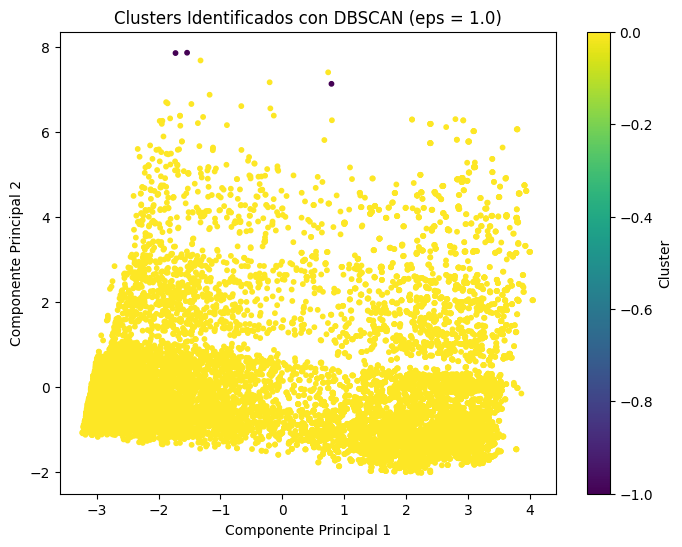


Comparación de Silhouette Scores:
K-Means (mejor número de clusters): 0.6142
DBSCAN (mejor eps): 0.5627


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

# Configurar preprocesamiento (reutilizando el existente)
pipeline_dbscan = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocesamiento combinado
    ('pca', pca)  # Reducir a 2 dimensiones para facilitar visualización
])

# Transformar los datos
X_pca_dbscan = pipeline_dbscan.fit_transform(data_clustering)

# Probar diferentes valores de eps para DBSCAN
eps_values = [0.3, 0.5, 0.7, 1.0]
min_samples = 5  # Fijo como ejemplo
silhouette_scores_dbscan = {}

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_pca_dbscan)

    # Verificar si DBSCAN encontró más de un cluster
    if len(set(labels)) > 1:
        silhouette_avg = silhouette_score(X_pca_dbscan, labels)
        silhouette_scores_dbscan[eps] = silhouette_avg
    else:
        silhouette_scores_dbscan[eps] = "N/A (1 cluster encontrado)"

# Resultados de DBSCAN
print("Silhouette Scores para DBSCAN con diferentes eps:")
for eps, score in silhouette_scores_dbscan.items():
    print(f"eps = {eps}: Silhouette Score = {score}")

# Visualizar los clusters para el mejor eps
best_eps = max((eps for eps in eps_values if silhouette_scores_dbscan[eps] != "N/A"),
               key=lambda eps: silhouette_scores_dbscan[eps])
dbscan_best = DBSCAN(eps=best_eps, min_samples=min_samples)
labels_best = dbscan_best.fit_predict(X_pca_dbscan)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca_dbscan[:, 0], X_pca_dbscan[:, 1], c=labels_best, cmap='viridis', s=10)
plt.title(f"Clusters Identificados con DBSCAN (eps = {best_eps})")
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

# Comparar Silhouette Scores de K-Means y DBSCAN
print("\nComparación de Silhouette Scores:")
print(f"K-Means (mejor número de clusters): {optimal_score.round(4)}")
print(f"DBSCAN (mejor eps): {silhouette_scores_dbscan[best_eps].round(4)}")




=== Mejores parámetros para DBSCAN ===
Mejores parámetros: {'eps': 1.0, 'min_samples': 5}
Mejor Silhouette Score: 0.5627
Puntos etiquetados como ruido: 3 (0.02%)


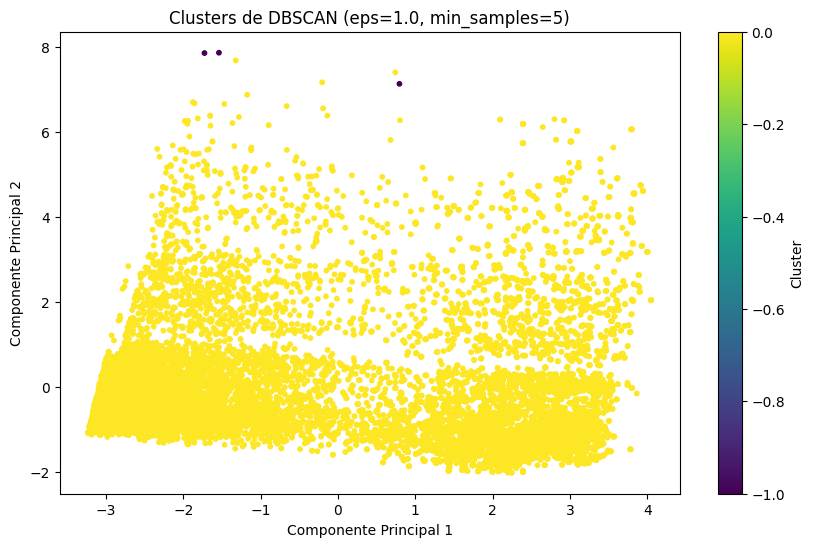


=== Comparación de Silhouette Scores ===
K-Means (clusters=3): 0.6142
DBSCAN (eps=1.0, min_samples=5): 0.5627


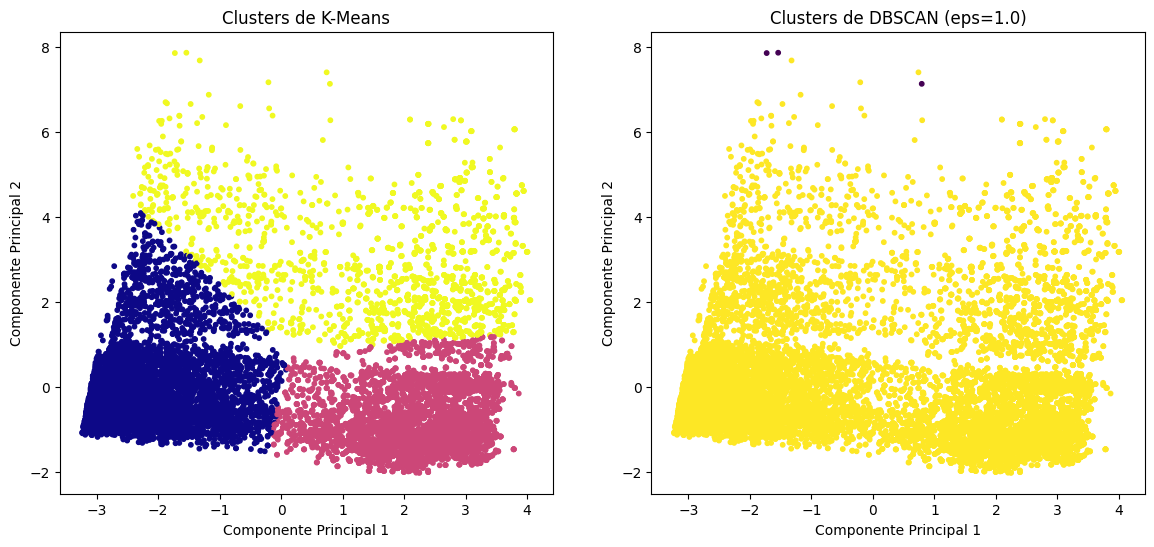

In [ ]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import ParameterGrid
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Selección de columnas relevantes
selected_columns = [
    'overall', 'review_dayofweek', 'review_month', 'review_year',
    'traveller_type', 'cabin', 'seat_comfort', 'cabin_service', 'airline',
    'food_bev', 'ground_service', 'value_for_money', 'route_distance',
    'route_time_minutes', "recommended"
]
data_clustering = data_clustering[selected_columns]

# Separar columnas numéricas y categóricas
num_features = ['overall', 'review_dayofweek', 'review_month', 'review_year',
                'seat_comfort', 'cabin_service', 'food_bev', 'ground_service',
                'value_for_money', 'route_distance', 'route_time_minutes', "recommended"]
cat_features = ['traveller_type', 'cabin', 'airline']

# Crear transformadores para numéricas y categóricas
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop='first', sparse_output=False)  # Cambiar a sparse_output=False si es sklearn>=1.2

# Preprocesamiento combinado
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

# Reducir dimensionalidad con PCA
pca = PCA(n_components=2, random_state=42)

# Pipeline para preprocesar y reducir dimensiones
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca)
])

# Transformar los datos
X_pca = pipeline.fit_transform(data_clustering)

# --- Optimización de DBSCAN ---
# Rango de parámetros ajustado
param_grid = {
    'eps': np.arange(0.8, 1.2, 0.1),  # Valores más finos alrededor de 1.0
    'min_samples': [3, 5, 10]
}

best_score = -1
best_params = None
silhouette_scores_dbscan = {}

for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = dbscan.fit_predict(X_pca)

    # Evaluar solo si hay más de un cluster
    if len(set(labels)) > 1 and -1 in labels:
        score = silhouette_score(X_pca, labels)
        silhouette_scores_dbscan[f"eps={params['eps']}, min_samples={params['min_samples']}"] = score
        if score > best_score:
            best_score = score
            best_params = params

print("\n=== Mejores parámetros para DBSCAN ===")
print(f"Mejores parámetros: {best_params}")
print(f"Mejor Silhouette Score: {best_score:.4f}")

# Analizar ruido
dbscan_best = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
labels_dbscan = dbscan_best.fit_predict(X_pca)
num_noise = sum(labels_dbscan == -1)
total_points = len(labels_dbscan)
print(f"Puntos etiquetados como ruido: {num_noise} ({(num_noise / total_points) * 100:.2f}%)")

# Visualizar clusters de DBSCAN
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_dbscan, cmap='viridis', s=10)
plt.title(f"Clusters de DBSCAN (eps={best_params['eps']}, min_samples={best_params['min_samples']})")
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

# --- Comparación con K-Means ---
# Pipeline para K-Means
optimal_clusters = 3  # Cambiar según resultados previos
pipeline_kmeans = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('kmeans', KMeans(n_clusters=optimal_clusters, random_state=42))
])
pipeline_kmeans.fit(data_clustering)
labels_kmeans = pipeline_kmeans.named_steps['kmeans'].labels_

# Evaluar Silhouette Scores
silhouette_dbscan = silhouette_score(X_pca, labels_dbscan)
silhouette_kmeans = silhouette_score(X_pca, labels_kmeans)

print("\n=== Comparación de Silhouette Scores ===")
print(f"K-Means (clusters={optimal_clusters}): {silhouette_kmeans:.4f}")
print(f"DBSCAN (eps={best_params['eps']}, min_samples={best_params['min_samples']}): {silhouette_dbscan:.4f}")

# Visualización comparativa
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, cmap='plasma', s=10)
plt.title("Clusters de K-Means")
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_dbscan, cmap='viridis', s=10)
plt.title(f"Clusters de DBSCAN (eps={best_params['eps']})")
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

plt.show()


El modelo con DSBAN es menos bueno que el  de K -means, asi que por ello nos quedamos con k-means:

K-Means (clusters=3): 0.6142
DBSCAN (eps=1.0, min_samples=5): 0.5627

### Segmentación de Clientes y Clustering

El clustering permite identificar distintos grupos de clientes con características y necesidades similares, funcionando como un primer acercamiento a la comprensión de los diferentes tipos de clientes que utiliza la aerolínea. Esta segmentación es clave para personalizar los esfuerzos de mejora, adaptando el servicio según las expectativas y preferencias de cada grupo.